In [199]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.api.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings("ignore")

**Veri Seti Yolu ve Sınıf İsimlerinin Listelenmesi**

**Veri Seti Yolunun Tanımlanması**: İlk olarak, veri setinin bulunduğu dizin (directory) fish_dir değişkeni ile tanımlanır. Bu, veri setinin bulunduğu yolun bilgisini tutar. Kaggle'da bir veri setini kullanırken, veri setinin adresini doğru şekilde yazmak, verilere erişmek için çok önemlidir.

In [164]:
# Balık görüntü veri setinin bulunduğu dizin
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# Veri setindeki farklı balık türlerinin bulunduğu klasörleri buluyoruz
# Klasör adı '.' içermeyenleri filtreliyoruz, yani dosya olanları çıkarıyoruz
classes = [i for i in os.listdir(fish_dir) if '.' not in i]
print(classes)

['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet', 'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream']


# Görüntü Yolları ve Sınıf Etiketlerinin DataFrame'e Dönüştürülmesi:
Bu kod bloğu, bir klasördeki görüntü dosyalarının dosya yollarını ve bu görüntülerin ait olduğu sınıf etiketlerini toplayarak bir Pandas DataFrame oluşturur. İlk olarak, boş label ve path listeleri tanımlanır. label listesi görüntülerin etiketlerini yani hangi sınıfa (klasör adı) ait olduğunu, path listesi ise görüntülerin dosya yollarını saklar. os.walk(fish_dir) koduyla belirtilen ana dizin içerisindeki tüm alt klasörler ve bu klasörlerdeki dosyalar taranır. Ancak, "GT" olarak adlandırılan ground truth maskeleri hariç tutulur. Yalnızca .png uzantısına sahip dosyalar işlenir; bu dosyalar için dosyanın bulunduğu klasör adı label listesine eklenir ve dosyanın tam yolu path listesine eklenir.

Son olarak, toplanan label ve path listeleri Pandas DataFrame yapısına dönüştürülür. DataFrame'de path sütunu görüntü dosyalarının yollarını, label sütunu ise bu görüntülerin sınıf etiketlerini içerir. Bu işlem, veri setini model eğitimi için düzenli bir şekilde organize eder ve veri setindeki görüntülerin erişimini kolaylaştırır.

In [165]:
# Görsellerin etiketlerini ve yollarını saklamak için listeler oluşturuyoruz
label = []  # etiket
path = []  # yol

# Tüm dizin ve dosyaları dolaşarak görsellerin yollarını ve etiketlerini listelere ekliyoruz
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        # Yalnızca '.png' uzantılı dosyaları ekliyoruz
        if os.path.splitext(filename)[-1] == '.png':
            # Dizin adı 'GT' içermiyorsa (bu dizindeki veriler kullanılmıyor)
            if dir_name.split()[-1] != 'GT':
                # Etiketi (balık türünü) ekliyoruz
                label.append(os.path.split(dir_name)[-1])
                # Dosya yolunu ekliyoruz
                path.append(os.path.join(dir_name, filename))
                
# Görüntü yolları ve etiketlerin bulunduğu DataFrame oluşturuyoruz
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

data

path            label
0     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
...                                                 ...              ...
8995  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8996  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8997  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8998  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8999  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream

[9000 rows x 2 columns]

**Veri Seti Hakkında Bilgiler Almak:**

Bu kod bloğunda veri setindeki ilk beş satırı ve son beş satırı görüntülemeyi , veri seti hakkında genel bilgi almayı , veri setindeki her bir dosyada kaç tane veri olduğunu görüntülüyoruz.

In [166]:
# Veri setinin son beş satırını görüntülüyoruz
data.tail()

path          label
8995  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream
8996  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream
8997  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream
8998  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream
8999  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream

In [167]:
# Veri setinin ilk beş satırını görüntülüyoruz
data.head()

path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel

In [168]:
# Veri seti hakkında genel bilgi alıyoruz (satır sayısı, sütun sayısı, veri tipleri)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [169]:
# Her bir sınıfta kaç tane örnek olduğunu sayıyoruz
data['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

# 9 Sınftan Örnekler Gösterme:

Bu kod bloğu, bir veri kümesindeki her sınıftan bir görselin gösterildiği bir görüntüleme işlemi gerçekleştirir. Kodun amacı, her sınıftan bir örnek görüntüyü alıp bir grafik üzerinde görselleştirmektir. İşte kodun adım adım açıklaması:

Başlangıç ve Genel Yapı *cn = 0*: Bu değişken, subplot'ların (alt grafiklerin) indeksini izlemek için kullanılır. Başlangıçta 0 olarak ayarlanmıştır. **plt.figure(figsize=(20, 20))******: Bu satır, 20x20 boyutlarında bir grafik oluşturur. figsize parametresi, görüntünün boyutlarını belirler ve burada büyük bir grafik alanı yaratılır.

Veri Kümesindeki Benzersiz Sınıfları Dolaşma **for unique_label in data['label'].unique():**: Bu satır, veri kümesindeki label (etiket/sınıf) sütununda bulunan benzersiz (unique) sınıfları döngüye sokar. Yani, her bir sınıf için bir döngü başlatır. **data['label']**: Veri çerçevesindeki etiket sütununa erişir. **.unique()**: Bu metot, etiket sütununda bulunan benzersiz sınıfları döndürür. Aynı sınıftan olan tekrarları kaldırır. 3. Her Sınıftan Bir Görüntüyü Gösterme **plt.subplot(3, 3, cn + 1)**: 3x3'lük bir ızgara şeklinde alt grafikler (subplot) oluşturur. Toplamda 9 grafik olacak şekilde ayarlanmıştır. Bu, her sınıf için bir alt grafik yerleştirir. **cn + 1**, alt grafiklerin sırasını belirtir.

**plt.imshow(plt.imread(data[data['label'] == unique_label].iloc[0, 0])):**

**data[data['label'] == unique_label]**: Bu ifade, veri kümesinden o anki benzersiz sınıfa (unique_label) sahip tüm satırları alır. .**iloc[0, 0]**: Bu satır, seçilen sınıftaki ilk görüntüyü seçer. **.iloc[0, 0]** ile veri çerçevesinin ilk satırının ve ilk sütununun içeriğini alır (görüntünün dosya yolu veya adı olabilir). **plt.imread()**: Seçilen görüntü dosyasını okur. **plt.imshow()**: Okunan görüntüyü grafikte gösterir. 4. Başlık ve Diğer Ayarlar **plt.title(unique_label)**: Görüntünün başlığı olarak, mevcut sınıf (unique_label) yazılır. Böylece her bir görüntünün üzerinde hangi sınıfa ait olduğu yazılır.

**plt.axis('off')**: Grafiklerde eksenlerin görünmemesi için eksenler kapatılır. Böylece sadece görüntüler görünür olur.

Alt Grafik Sırasını Güncelleme **cn += 1**: Her döngüde cn değişkeni bir artırılır. Bu, bir sonraki görüntünün bir sonraki alt grafik alanına yerleştirilmesini sağlar.

Grafiği Gösterme **plt.show()**: Son olarak, tüm görüntüleme işlemi tamamlandıktan sonra grafiği ekrana getirir. Alt grafiklerde her sınıftan bir örnek olacak şekilde gösterir.

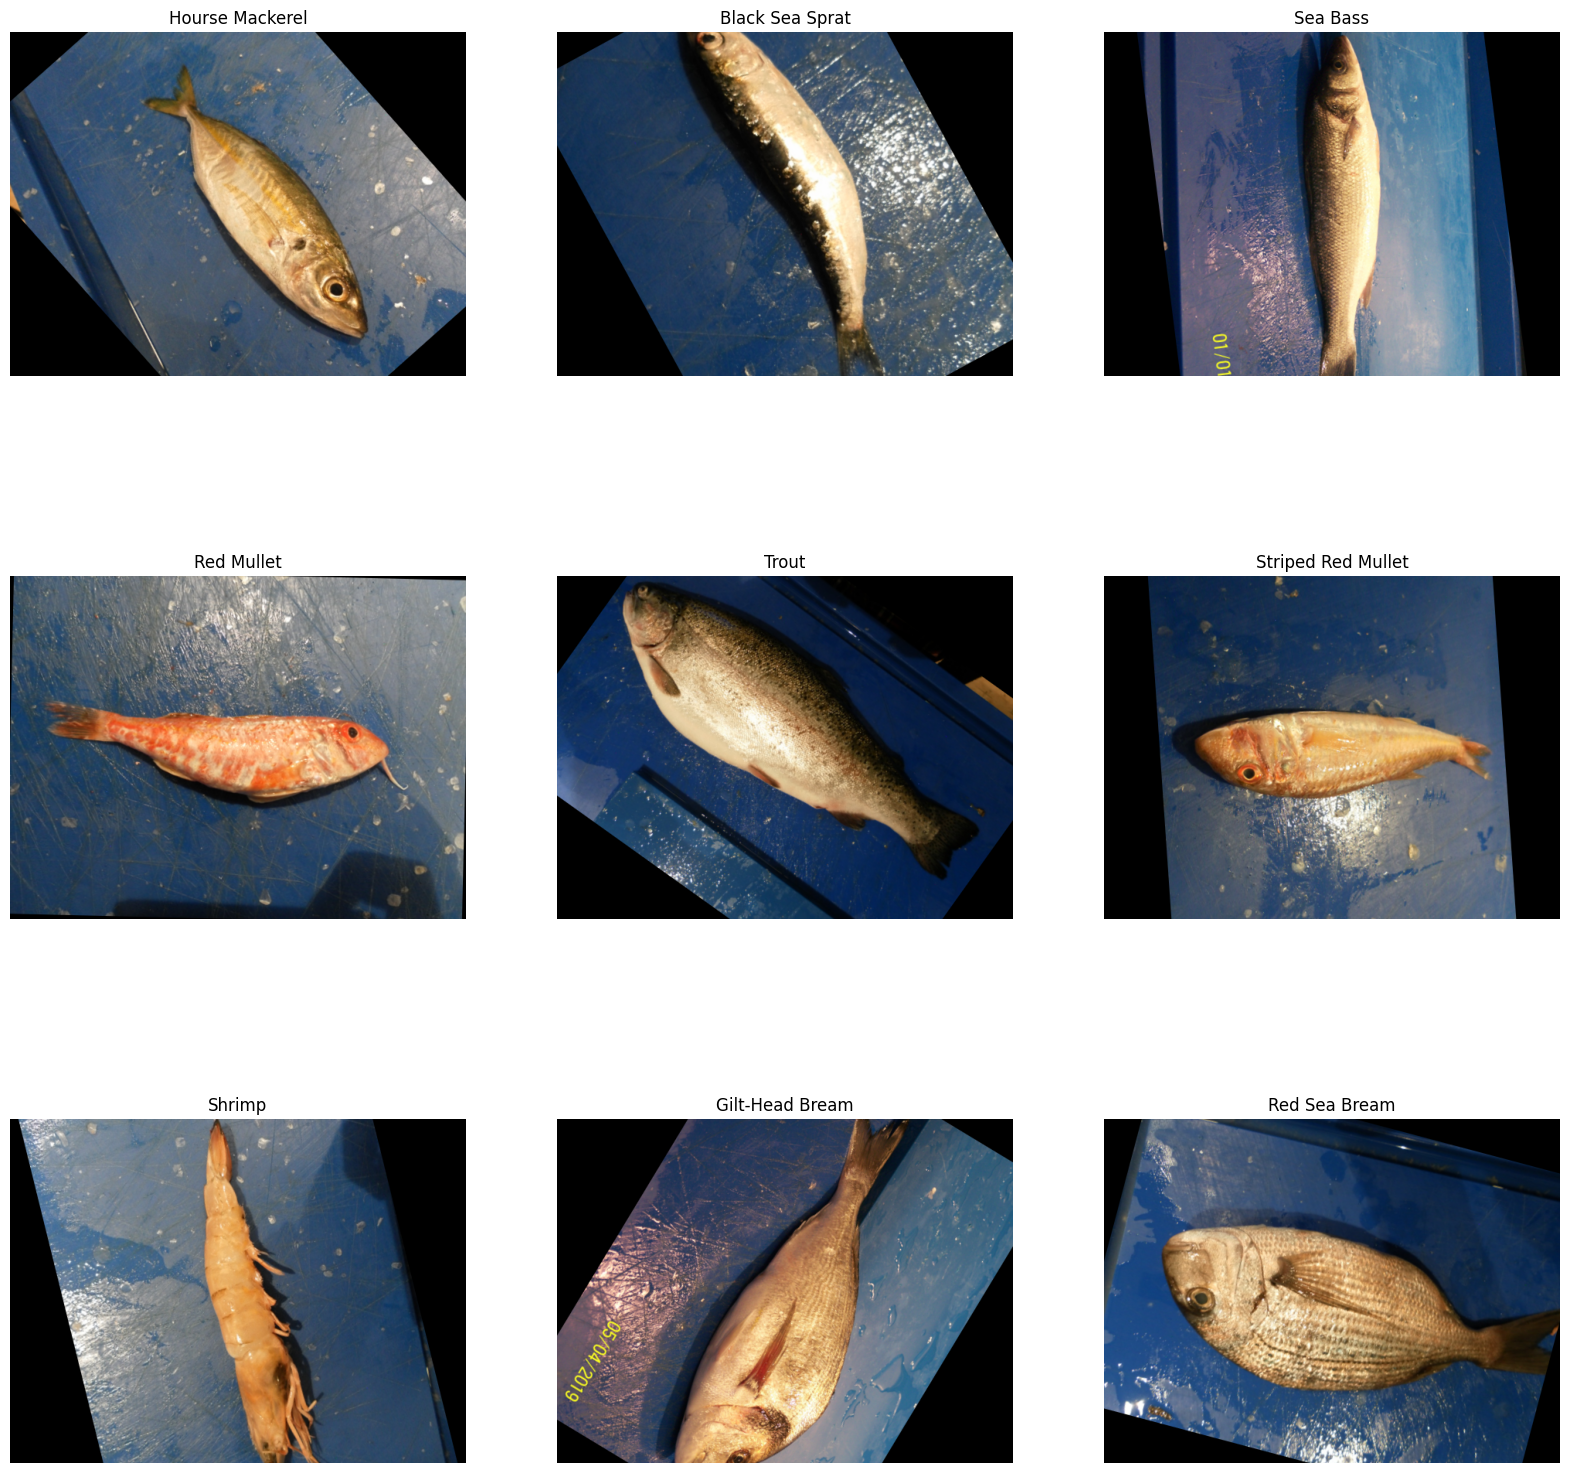

In [170]:
# Görsellerden örnekler gösteriyoruz, her sınıftan bir tane olacak şekilde
cn = 0
plt.figure(figsize=(20, 20))
for unique_label in data['label'].unique():
    plt.subplot(3, 3, cn + 1)
    plt.imshow(plt.imread(data[data['label'] == unique_label].iloc[0, 0]))
    plt.title(unique_label)
    plt.axis('off')
    cn += 1
plt.show()

Bu kod, Kaggle üzerinde çalışırken veri setini eğitim (train) ve test (test) olarak ikiye böler. Eğitim verisi, modelimizi eğitmek için kullanılırken test verisi, modelin performansını değerlendirmek için kullanılır. Veri setini ayırmak, modeli gerçek dünyadaki verilere karşı nasıl performans gösterdiğini test edebilmemiz için önemlidir.

**1.train_test_split() Fonksiyonu**: train_test_split() fonksiyonu, scikit-learn kütüphanesinden gelir ve verilen bir veri kümesini ikiye böler: eğitim ve test verisi olarak. Kaggle'da veri seti genellikle tek bir dosya halinde verilir ve bu veri setini ikiye ayırarak modelimizi önce eğitip sonra test ederiz.

In [171]:
#Veri setini eğitim ve test olarak ayırıyoruz (test oranı %20)
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

**Parametreler:**
**data:** Bölünecek veri seti. Genelde Kaggle'da pandas DataFrame olarak yüklenen bir veri setidir.

**test_size**=0.2: Test veri setinin oranını belirler. Burada %20 test, %80 eğitim için ayarlanmıştır. Yani veri kümenizin %80'i model eğitimi için, %20'si model performansını test etmek için kullanılacak.

**shuffle**=True: Veriler bölünmeden önce karıştırılır. Kaggle'da veri genellikle sıralı gelir (örneğin: veriler belli bir tarihe göre sıralanmış olabilir), bu yüzden verileri karıştırmak (shuffle) daha dengeli bir eğitim ve test verisi sağlar.

**random_state**=42: Rastgelelik için sabit bir tohum değeridir. Aynı kodu her çalıştırdığınızda aynı şekilde bölünmüş bir veri seti elde edersiniz. Kaggle yarışmalarında kodun tekrar üretilebilirliği (reproducibility) çok önemlidir, bu yüzden random_state=42 gibi sabit bir değer kullanılır.

**2. train_data ve test_data**
Fonksiyon iki parçayı döndürür:

**train_data**: Eğitim veri seti (%80).
**test_data**: Test veri seti (%20).

**3. Eğitim ve Test Verisi Boyutlarını Yazdırma**
Bu kısım, bölme işleminden sonra eğitim ve test verisinin boyutlarını (satır ve sütun sayısı) ekrana yazdırır:

In [172]:
#Eğitim veri kümesinin satır ve sütun sayısını gösterir.
print(train_data.shape)
#Test veri kümesinin satır ve sütun sayısını gösterir.
print(test_data.shape)

(7200, 2)
(1800, 2)


Bu kodda, Keras'ın **ImageDataGenerator** sınıfı kullanılarak eğitim, doğrulama ve test veri setleri için görüntülerin ön işlenmesi ve isteğe bağlı olarak veri artırma (data augmentation) işlemleri gerçekleştirilmiştir. Kodda yer alan üç farklı veri üreteci (train_generator, val_generator, test_generator) açıklanacaktır.



# 1. ImageDataGenerator Nedir?
ImageDataGenerator sınıfı, görüntüleri eğitim sırasında yüklerken gerçek zamanlı olarak çeşitli ön işleme ve veri artırma teknikleri uygulayan bir veri üreteç sınıfıdır. Bu, modelin performansını artırmaya ve overfitting'i azaltmaya yardımcı olur. Ayrıca, sınırlı sayıda veri ile daha iyi genel sonuçlar elde edilmesine olanak tanır.

**2. Eğitim Verisi için train_generator**

In [173]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest',
    validation_split=0.2
)

**rescale=1./255**: Rescaling işlemi, piksel değerlerini 0-255 aralığından 0-1 aralığına indirir. Bu normalizasyon, modelin daha hızlı ve daha stabil bir şekilde öğrenmesine yardımcı olur. (Görüntülerin piksel değeri 0 ile 255 arasında olduğu için, 1/255 ile çarparak değerler 0-1 aralığına getirilir.)

**Veri artırma işlemleri (yorum satırında):**

**rotation_range**=20: Görüntüleri rastgele 20 dereceye kadar döndürme işlemi. Modelin farklı açılardaki görüntüleri öğrenmesini sağlar.

**width_shift_range**=0.2: Görüntüleri yatayda yüzde 20'ye kadar kaydırma işlemi.

**height_shift_range**=0.2: Görüntüleri dikeyde yüzde 20'ye kadar kaydırma.

**shear_range**=0.2: Görüntülerde kesme (shear) dönüşümleri uygulama.

**zoom_range**=0.2: Görüntüleri yüzde 20 oranında zoom yaparak büyütme veya küçültme.

**horizontal_flip**=True: Görüntüleri yatayda çevirmek. Örneğin, bir balığı sola bakan bir görüntüde sağa çevirmek gibi. Bu simetriyi öğrenmeye yardımcı olur.

**fill_mode**='nearest': Kaydırma veya döndürme sonrası görüntünün dışındaki alanları doldururken kullanılacak olan yöntemi belirler. Bu örnekte, dıştaki piksel değerlerine en yakın olanlarla doldurma yapılır.

**validation_split**=0.2: Bu parametre, eğitim veri setinin %20'sinin doğrulama (validation) için ayrılacağını belirtir. Yani, eğitim veri setinin bir kısmı modelin doğrulaması için kullanılacak.

Yorum satırındaki veri artırma (augmentation) işlemleri devre dışı bırakılmış, ancak kullanıldığında eğitim sırasında modelin görüntülerin farklı varyasyonlarıyla (döndürme, kaydırma, yakınlaştırma vb.) karşılaşmasını sağlar. Veri artırma overfitting'i engelleyerek modelin daha genel sonuçlar elde etmesine yardımcı olur.

**3. Doğrulama Verisi için val_generator**

In [174]:
val_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

**Doğrulama verileri için veri üreteci:**

**rescale**=1./255: Aynı şekilde, doğrulama görüntülerindeki piksel değerleri de 0-255 aralığından 0-1 aralığına indirgenir.

**validation_split**=0.2: Doğrulama seti de eğitim verisi ile aynı veri kümesinden %20'lik bir ayrımla alınır.

Doğrulama verisi, modelin her epoch sonunda performansını test etmek için kullanılır. Bu veri setinde veri artırma uygulanmaz, çünkü modelin gerçek dünyada karşılaşacağı görüntülere benzer şekilde performansını ölçmek amaçlanır.

**4. Test Verisi için test_generator**

In [175]:
test_generator = ImageDataGenerator(rescale=1./255)

**Test verileri için veri üreteci:**

**rescale**=1./255: Test verilerinde de rescale işlemi uygulanır. Piksel değerleri 0-1 aralığına normalleştirilir.

Test verisi, eğitim tamamlandıktan sonra modelin genel performansını değerlendirmek için kullanılır. Bu veri seti, modelin daha önce hiç görmediği verilerden oluşur. Yani, bu aşamada veri artırma uygulanmaz, çünkü gerçek dünyadaki verilerde de benzer veri artırma işlemleri yapılmayacaktır.

Bu kodda, **flow_from_dataframe** yöntemi kullanılarak eğitim, doğrulama ve test veri setleri için görüntü verileri yükleniyor ve modelin eğitimi için veri üreteçleri oluşturuluyor. Kod, veri setindeki görüntüleri istenen şekillerde ön işleme tabi tutuyor ve sınıfları doğru şekilde etiketleyerek modelin eğitimi, doğrulaması ve testi için hazırlıyor. Aşağıda bu kodun detaylı açıklaması yer almakta:

**1. Eğitim Verisi İçin train_images**

In [176]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True, 
    seed=42, 
    subset='training'
)

Found 5760 validated image filenames belonging to 9 classes.


**dataframe=train_data**: Eğitim veri seti olarak kullanılan train_data DataFrame'ini belirtir. Bu DataFrame, her görüntünün dosya yolu (path) ve etiketlerini (label) içerir.

**x_col**='path': Görüntülerin bulunduğu sütunu belirtir. Burada, path sütunu görüntü dosyalarının yolunu içerir.

**y_col**='label': Görüntülerin sınıflarını (etiketlerini) belirtir. label sütunu, her görüntünün hangi sınıfa ait olduğunu belirtir.

**target_size**=(28, 28): Görüntüler, modelin giriş katmanına uygun boyutlarda olacak şekilde 28x28 piksel boyutlarına yeniden boyutlandırılır. Eğer görüntüler bu boyutlarda değilse, bu işlemle boyutlandırılır.

**color_mode**='rgb': Görüntülerin renk modu olarak RGB kullanılır. Bu, her görüntünün üç kanallı olduğunu ifade eder (kırmızı, yeşil, mavi).

**class_mode**='categorical': Sınıflar arasında kategorik bir sınıflandırma yapılacağını belirtir. Bu modda, sınıf etiketleri tek sıcak kodlama (one-hot encoding) formatında olacak, yani her sınıf için bir vektör üretilecektir.

**batch_size**=64: Eğitim sırasında her iterasyonda 64 görüntüden oluşan bir batch (toplu işlem) kullanılacak.

**shuffle**=True: Eğitim verileri her epoch'ta rastgele karıştırılacak. Bu, modelin veri setine ezberlemeden öğrenmesine yardımcı olur.

**seed**=42: Rastgelelik işlemleri için sabit bir tohum değeri sağlar, böylece deneyler tekrarlandığında aynı sonuçlar elde edilebilir.

**subset**='training': ImageDataGenerator'da kullanılan doğrulama bölmesi (validation_split) ile uyumlu olarak, bu veri kümesi sadece eğitim verilerini içerecek şekilde ayrıştırılmıştır.

**2. Doğrulama Verisi İçin val_images**

In [177]:
val_images = val_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True, 
    seed=42, 
    subset='validation' 
)

Found 1440 validated image filenames belonging to 9 classes.


Bu bölüm, doğrulama (validation) verilerini oluşturmak için kullanılır ve eğitim verisiyle hemen hemen aynı yapıya sahiptir. Tek fark, subset='validation' ile sadece eğitim verisinin %20'lik kısmını doğrulama verisi olarak kullanmasıdır. Doğrulama verileri, modelin her epoch sonunda ne kadar iyi performans gösterdiğini kontrol etmek için kullanılır.

**shuffle**=True: Eğitimde olduğu gibi, doğrulama verileri de rastgele karıştırılır. Ancak burada karıştırma işlemi çok önemli değildir çünkü doğrulama verisi eğitim sırasında modelin güncellenmesi için kullanılmaz.

**3. Test Verisi İçin test_images**

In [178]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=False 
)

Found 1800 validated image filenames belonging to 9 classes.


**Test veri seti: test_data** adlı DataFrame'den gelen test verileri kullanılır. Bu veri kümesi, modelin eğitimi tamamlandıktan sonra performansını bağımsız ve daha önce hiç görülmemiş veriler üzerinde değerlendirmek için kullanılır.

**shuffle**=False: Test verilerinde karıştırma yapılmaz. Bunun nedeni, test verilerinde veri sırasının korunmasının önemli olmasıdır. Çünkü tahminler, veri setindeki sırayla yapılacak ve doğru sonuçlarla karşılaştırılacaktır.

# 1. Modelin Tanımlanması ve Katmanların Eklenmesi

In [179]:
model = tf.keras.models.Sequential()

**Sequential API**, katmanları sıralı bir şekilde eklemeye olanak tanıyan bir model türüdür. Bu API, her katmanın yalnızca bir önceki katmandan gelen çıktıyı girdi olarak kabul ettiği durumlar için kullanılır.

# 2. Girdi (Input) Katmanı

In [180]:
model.add(tf.keras.layers.Flatten())

**Flatten Katmanı**: Bu katman, girdi olarak gelen 28x28 boyutlarındaki görüntüleri (her biri 3 renk kanallı) düzleştirir. Yani, her bir görüntüyü 28x28x3 = 2352 boyutlu bir vektöre dönüştürür. Bu işlem, tam bağlantılı katmanlara (Dense layers) geçişi sağlar.

**input_shape**=(28, 28, 3): Girdinin şekli (yükseklik, genişlik, kanal sayısı) burada belirtilir. Görüntüler 28x28 piksel boyutunda ve 3 kanallı (RGB) renk modunda olduğu için giriş boyutu bu şekilde tanımlanmıştır.

# 3. Gizli (Hidden) Katmanlar
Modelin asıl öğrenme işlevini gerçekleştiren katmanlardır. Bu katmanlar, girdiler üzerinde belirli hesaplamalar yaparak verilerden anlamlı özellikler öğrenir.

**İlk Gizli Katman:**

In [181]:
model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

**Dense(1024)**: Tam bağlantılı katman, 1024 adet nörondan oluşur. Bu katman, giriş vektöründen 1024 boyutlu bir çıktı üretir.

**activation**='relu': Aktivasyon fonksiyonu olarak ReLU (Rectified Linear Unit) kullanılmıştır. ReLU, negatif girdileri 0 yapar, pozitif girdileri ise olduğu gibi bırakır, bu da modelin doğrusal olmayan ilişkileri öğrenmesine yardımcı olur.

**kernel_regularizer**=regularizers.l2(0.001): Bu katmana L2 regülarizasyonu eklenmiştir. L2 regülarizasyonu, ağırlıkların büyüklüğünü sınırlayarak aşırı öğrenmeyi (overfitting) önlemeye yardımcı olur. 0.001 parametresi, regülarizasyon gücünü kontrol eder.

**BatchNormalization()**: Bu katman, modelin her bir mini-batch'teki aktivasyonlarının ortalamasını ve varyansını normalize eder. Bu, eğitimi hızlandırır ve modelin daha kararlı hale gelmesine yardımcı olur.

**Dropout(0.2)**: Bu katman, her eğitim iterasyonunda nöronların %20'sini rastgele devre dışı bırakır. Dropout, modelin aşırı öğrenmesini (overfitting) önlemek için kullanılan bir tekniktir.

D**iğer Gizli Katmanlar:**
Benzer şekilde, diğer gizli katmanlar da aynı işlevleri yerine getirir.

**İkinci Gizli Katman:**

In [182]:
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())

**Dense(512)**: Bu katmanda 512 nöron bulunur. Aynı ReLU aktivasyon fonksiyonu ve L2 regülarizasyonu kullanılmıştır. Batch normalization, bu katman için de aktivasyonları normalize eder. 

**Üçüncü Gizli Katman:**

In [183]:
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))

256 nöron ve aynı aktivasyon ile L2 regülarizasyonuna sahip.
**Dropout(0.2)**, yine aşırı öğrenmeyi önlemek için %20 nöronu rastgele devre dışı bırakır.

**Dördüncü Gizli Katman:**

In [184]:
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

128 nöronlu bir tam bağlantılı katman.

**Beşinci Gizli Katman:**

In [185]:
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))

64 nöronlu bir katman, yine ReLU aktivasyon fonksiyonu ve %20 Dropout ile birlikte.

# 4. Çıkış (Output) Katmanı

In [186]:
model.add(tf.keras.layers.Dense(9, activation='softmax'))

**Dense(9)**: Çıkış katmanında 9 nöron bulunur, çünkü modelin 9 farklı sınıfa sınıflandırma yapması gerekiyor.

**activation**='softmax': Softmax aktivasyon fonksiyonu, çok sınıflı sınıflandırma problemlerinde kullanılır. Her bir sınıf için olasılık hesaplar ve toplamı 1'e eşit olan olasılıklar üretir. Yani, bu katman her sınıf için bir olasılık değeri döndürür ve model en yüksek olasılığa sahip sınıfı tahmin eder.

Modeldeki parametre sayısı ve katmanları göstermek için summary fonksiyonunu kullandım.

In [187]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# 1. EarlyStopping Callback

In [188]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

EarlyStopping callback’i, modelin eğitim sürecinde kullanılacak bir kontrol mekanizmasıdır. Eğitimin belirli bir aşamasında, modelin performansını izlemek ve erken durdurmak için kullanılır. Buradaki parametrelerin anlamı:

**monitor**='val_loss': Modelin doğrulama (validation) kaybını izler. Eğer bu değer, belirli bir sayıda (patience) epoch boyunca iyileşmezse eğitim durdurulacaktır.

**patience**=5: Eğitim sırasında kaybın 5 ardışık epoch boyunca iyileşmemesi durumunda, erken durdurma gerçekleştirilecektir.

**restore_best_weights**=True: Eğitim durdurulduğunda, modelin en iyi ağırlıklarını geri yükleyecektir, böylece modelin doğrulama kaybını en aza indiren en iyi durumunu elde edersiniz.

# 2. Learning Rate Scheduler

In [189]:
def lr_scheduler(epoch, lr):
    if epoch >= 20:
        lr *= 0.990 
    return lr

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

**Learning Rate Scheduler** ise öğrenme oranını (learning rate) zamanla ayarlamak için kullanılır. Bu, modelin eğitiminde daha iyi sonuçlar elde etmek için önemlidir. Burada:

lr_scheduler fonksiyonu, eğitim dönemlerini (epoch) izler ve belirli bir dönemden sonra öğrenme oranını azaltır.

**if epoch >= 20**: Eğer eğitim 20. döneme ulaştıysa, öğrenme oranını %0.99 ile çarparak azaltır.

**return lr**: Güncellenmiş öğrenme oranını döndürür.
Bu callback, eğitim sürecinin ilerledikçe öğrenme oranını kademeli olarak azaltarak modelin daha iyi genelleştirme yapmasını sağlar.

# 3. Model Compilation

In [190]:
model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01), 
    loss='categorical_crossentropy',
    metrics=['accuracy','precision', 'recall', 'F1Score'],
)

**Modelin derlenmesi** kısmı, modelin eğitim sırasında nasıl davranacağını belirler. Burada kullanılan parametreler:

**optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01)**: Adagrad optimizasyon algoritmasını kullanarak modelin öğrenme oranını başlangıçta 0.01 olarak ayarlar. Adagrad, sık güncellenen parametreler için öğrenme oranını düşürerek, seyrek güncellenen parametreler için daha büyük bir öğrenme oranı sağlar.

**loss='categorical_crossentropy'**: Çok sınıflı sınıflandırma problemleri için kayıp fonksiyonu olarak categorical crossentropy kullanılır. Bu kayıp fonksiyonu, gerçek etiketler ile tahmin edilen etiketler arasındaki farkı ölçer.

**metrics=['accuracy','precision', 'recall', 'F1Score']**: Modelin performansını değerlendirmek için kullanılacak metriklerdir:

**accuracy**: Doğru tahminlerin oranını ölçer.
**precision**: Pozitif tahminlerin ne kadarının doğru olduğunu gösterir.
**recall**: Gerçek pozitiflerin ne kadarının doğru tahmin edildiğini gösterir.
**F1Score**Bu Python kodu, bir makine öğrenimi modelini eğitmek için kullanılır ve TensorFlow veya Keras gibi bir derin öğrenme kütüphanesi ile yazıldığına dair bir izlenim vermektedir.: Precision ve recall arasında bir denge sağlar; her ikisini de dikkate alarak bir sonuç verir.

Bu Python kodu, bir makine öğrenimi modelini eğitmek için kullanılır ve TensorFlow veya Keras gibi bir derin öğrenme kütüphanesi ile yazıldığına dair bir izlenim vermektedir.

In [191]:
results = model.fit(
    train_images, 
    epochs=10, 
    batch_size=64, 
    validation_data=val_images,
    callbacks=[early_stopping, lr_scheduler_callback]
)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 90s 904ms/step - F1Score: 0.2895 - accuracy: 0.2945 - loss: 4.6597 - precision: 0.6781 - recall: 0.0655 - val_F1Score: 0.3185 - val_accuracy: 0.3576 - val_loss: 4.5235 - val_precision: 0.9348 - val_recall: 0.0299 - learning_rate: 0.0100
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 83s 863ms/step - F1Score: 0.6212 - accuracy: 0.6283 - loss: 3.7590 - precision: 0.7956 - recall: 0.4367 - val_F1Score: 0.4852 - val_accuracy: 0.5035 - val_loss: 4.0590 - val_precision: 0.6865 - val_recall: 0.2007 - learning_rate: 0.0100
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 82s 860ms/step - F1Score: 0.7424 - accuracy: 0.7468 - loss: 3.3863 - precision: 0.8527 - recall: 0.6312 - val_F1Score: 0.7630 - val_accuracy: 0.7681 - val_loss: 3.4012 - val_precision: 0.8967 - val_recall: 0.5965 - learning_rate: 0.0100
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 83s 864ms/step - F1Score: 0.8278 - accuracy: 0.8287 - loss: 3.1516 - precision: 0.8841 - recall: 0.7567 - val_F1Score: 0.8140 - val_accur

**model.fit:**
Modelin eğitim sürecini başlatan bir işlevdir. Model, belirtilen eğitim verileri üzerinde eğitim yapılır.

**train_images:**
Modelin eğitilmesi için kullanılan ana eğitim veri setidir. Genellikle bu, giriş verileri (örneğin, resimler) ve bunlara karşılık gelen etiketleri (sınıf bilgileri) içerir.

**epochs=100:**
Modelin eğitim sürecinin toplam sayısını belirler. Burada model, eğitim verileri üzerinde 100 kez (epoch) çalıştırılacaktır. Her bir epoch, modelin tüm eğitim verileri üzerinde bir geçiş yapmasını ifade eder.

**batch_size=64:**
Modelin güncellenmesi için her bir adımda kullanılacak örnek sayısını belirtir. Örneğin, 64 örnek alındığında model ağırlıkları güncellenir. Daha büyük batch size değerleri, eğitim süresini kısaltabilirken, daha küçük değerler daha fazla güncelleme sağlar.

**validation_data=val_images:**
Eğitim sırasında modelin performansını değerlendirmek için kullanılan doğrulama veri setini belirtir. Model, her epoch sonunda bu veriler üzerinde performansını test eder. val_images, modelin daha önce görmediği veriler ile doğrulama yapılmasını sağlar.

**callbacks=[early_stopping, lr_scheduler_callback]:**
Eğitim sırasında belirli olaylara tepki vermek için kullanılan geri çağırma (callback) işlevleridir.
**early_stopping**: Bu, modelin doğrulama kaybı belirli bir sayıda epoch boyunca iyileşmezse (örneğin, 5 epoch) eğitim sürecini durdurmasına olanak tanır. Bu, aşırı uyum (overfitting) riskini azaltır.
**lr_scheduler_callback**: Bu, öğrenme oranını (learning rate) dinamik olarak ayarlamak için kullanılır. Belirli bir kritere bağlı olarak öğrenme oranı düşürülebilir, bu da modelin daha iyi öğrenmesini sağlayabilir.

Bu Python kodu, bir makine öğrenimi modelinin eğitim süreci sırasında kaydedilen kayıp (loss) ve doğruluk (accuracy) değerlerini görselleştirmek için Matplotlib kütüphanesini kullanır.

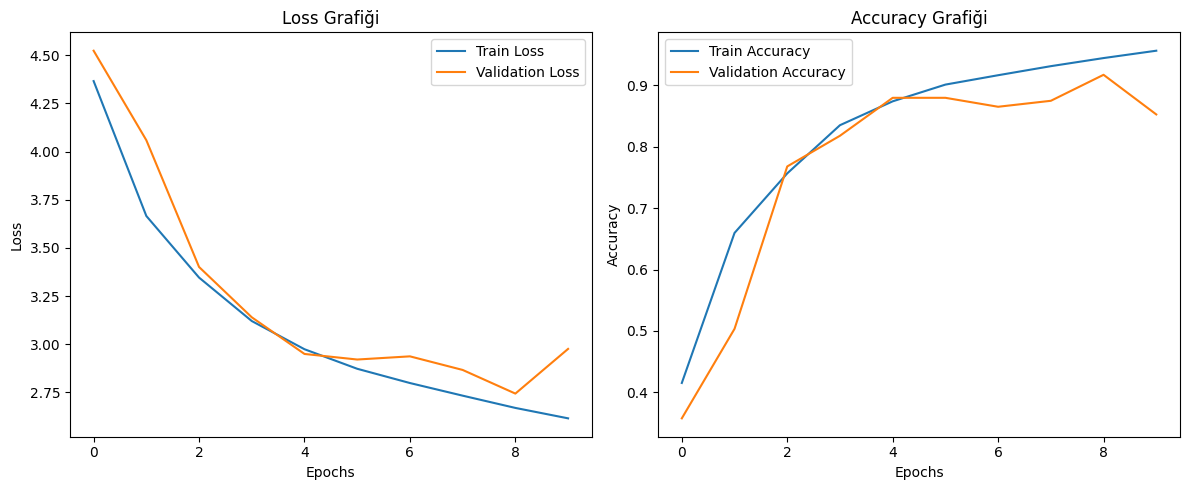

In [192]:
plt.figure(figsize=(12, 5))

# Loss değeri için grafikleri çizdirelim.
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy score grafikleri çizdirelim.
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


**plt.figure(figsize=(12, 5)):**

Bu satır, grafiğin boyutunu ayarlar. figsize parametresi, grafiğin genişliğini ve yüksekliğini inç cinsinden belirtir. Burada 12 inç genişliğinde ve 5 inç yüksekliğinde bir grafik oluşturulmaktadır.

**plt.subplot(1, 2, 1):**
Bu fonksiyon, 1 satır ve 2 sütundan oluşan bir alt grafik (subplot) oluşturur ve birinci subplot'u (soldaki) seçer. Bu bölümde kayıp (loss) değerleri için grafik çizilecektir.

**plt.plot(results.history['loss'], label='Train Loss')**:
Eğitim sırasında kaydedilen kayıp değerlerini çizer. results.history['loss'], modelin her epoch'taki eğitim kaybını içerir.

**plt.plot(results.history['val_loss'], label='Validation Loss'):**
Doğrulama setindeki kayıp değerlerini çizer. results.history['val_loss'], modelin her epoch'taki doğrulama kaybını içerir.

**plt.title('Loss Grafiği'):**
Grafiğe başlık ekler. Burada "Loss Grafiği" başlığı verilmektedir.

**plt.xlabel('Epochs'):**
X eksenine etiket ekler. Burada X ekseni "Epochs" olarak adlandırılmıştır.

**plt.ylabel('Loss'):**
Y eksenine etiket ekler. Y ekseni "Loss" olarak adlandırılmıştır.

**plt.legend():**
Grafikteki çizgelerin etiketlerini gösterir. Eğitim ve doğrulama kaybı için ayrı etiketler görüntülenir.

**plt.subplot(1, 2, 2):**
İkinci subplot'u (sağdaki) seçer. Bu bölümde doğruluk (accuracy) değerleri için grafik çizilecektir.

**plt.plot(results.history['accuracy'], label='Train Accuracy'):**
Eğitim sırasında kaydedilen doğruluk değerlerini çizer. results.history['accuracy'], modelin her epoch'taki eğitim doğruluğunu içerir.

**plt.plot(results.history['val_accuracy'], label='Validation Accuracy'):**
Doğrulama setindeki doğruluk değerlerini çizer. results.history['val_accuracy'], modelin her epoch'taki doğrulama doğruluğunu içerir.

**plt.title('Accuracy Grafiği'):**
Doğruluk grafiğine başlık ekler. Burada "Accuracy Grafiği" başlığı verilmektedir.

**plt.xlabel('Epochs'):**
X eksenine etiket ekler. Burada X ekseni "Epochs" olarak adlandırılmıştır.

**plt.ylabel('Accuracy'):**
Y eksenine etiket ekler. Y ekseni "Accuracy" olarak adlandırılmıştır.

**plt.legend()**:
Doğruluk grafiğindeki çizgelerin etiketlerini gösterir. Eğitim ve doğrulama doğruluğu için ayrı etiketler görüntülenir.

**plt.tight_layout():**
Alt grafiklerin düzenini daha iyi hale getirir. Bu, grafiklerin arasında daha iyi bir boşluk sağlayarak üst üste binmelerini önler.

**plt.show():**
Tüm grafiklerin gösterilmesini sağlar. Bu komut, oluşturulan grafiklerin görsel olarak görüntülenmesini sağlar.

Grafiklerde eğitim ve doğrulama verileri birbirine oldukça yakın hareket ediyor. Bu nedenle overfitting yaptığını söyleyemeyiz çünkü doğrulama başarımı da neredeyse eğitim başarımı kadar iyi performans gösteriyor.

# Model Değerlendirmesi:

Bu kod parçası, eğitilen derin öğrenme modelinin test verisi üzerindeki tahminlerini gerçekleştiriyor ve sınıf tahminlerini elde ediyor.

In [193]:
pred = model.predict(test_images)
pred_classes = np.argmax(pred, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step


**pred = model.predict(test_images)**: Bu satır, eğitilen modele test görüntülerini (test_images) girerek model tahminlerini (pred) elde ediyor. **model.predict()** fonksiyonu, test görüntülerini modele gönderir ve modelin ürettiği çıkış değerlerini döndürür. **pred_classes = np.argmax(pred, axis=1)**: Bu satır, pred değişkenindeki tahmin çıktılarını sınıf etiketlerine dönüştürüyor. **np.argmax()** fonksiyonu, her bir örnek (satır) için en yüksek tahmin değerine sahip olan indeksi (sınıf numarasını) bulur. **axis=1** parametresi, bu işlemin her bir örnek (satır) için ayrı ayrı yapılmasını sağlar. Sonuç olarak, pred_classes değişkeni, her bir test örneğinin tahmin edilen sınıf numaralarını içeren bir NumPy dizisi haline gelir.

Bu kod parçası, eğitilen modelin test verileri üzerindeki performans ölçümlerini hesaplamaktadır. 

In [194]:
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(test_images)

29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 717ms/step - F1Score: 0.8955 - accuracy: 0.8972 - loss: 2.8004 - precision: 0.9081 - recall: 0.8863


**test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(test_images) model.evaluate()** fonksiyonu, test görüntülerini (test_images) modele gönderir ve modelin bu görüntüler üzerindeki performansını ölçer. Fonksiyon, aşağıdaki performans ölçümlerini döndürür.

**test_loss**: Modelin test verileri üzerindeki kayıp değeri.

**test_accuracy**: Modelin test verileri üzerindeki doğruluk oranı.

**test_precision**: Modelin test verileri üzerindeki hassasiyet değeri.

**test_recall**: Modelin test verileri üzerindeki duyarlılık değeri.

**test_f1_score**: Modelin test verileri üzerindeki F1 skor değeri. Bu performans ölçümleri, modelin test verileri üzerindeki genel başarımını değerlendirmek için kullanılır.

**test_loss**: Modelin test verileri üzerindeki kayıp (hata) değeri. Düşük olması istenir. 

**test_accuracy**: Modelin test verileri üzerindeki doğru sınıflandırma oranı. Yüksek olması istenir. 

**test_precision**: Modelin doğru olarak tahmin ettiği pozitif örneklerin oranı. Yüksek olması istenir. 

**test_recall**: Modelin pozitif örnekleri doğru tahmin etme oranı. Yüksek olması istenir.

**test_f1_score**: Hassasiyet ve duyarlılık arasındaki denge. Yüksek olması istenir. Bu performans ölçümleri, modelin test verileri üzerindeki genel performansını değerlendirmek ve modeli iyileştirmek için kullanılabilir.

Bu kod parçası, eğitilen modelin test verileri üzerindeki performansını konfüzyon matrisi kullanarak görselleştiriyor.

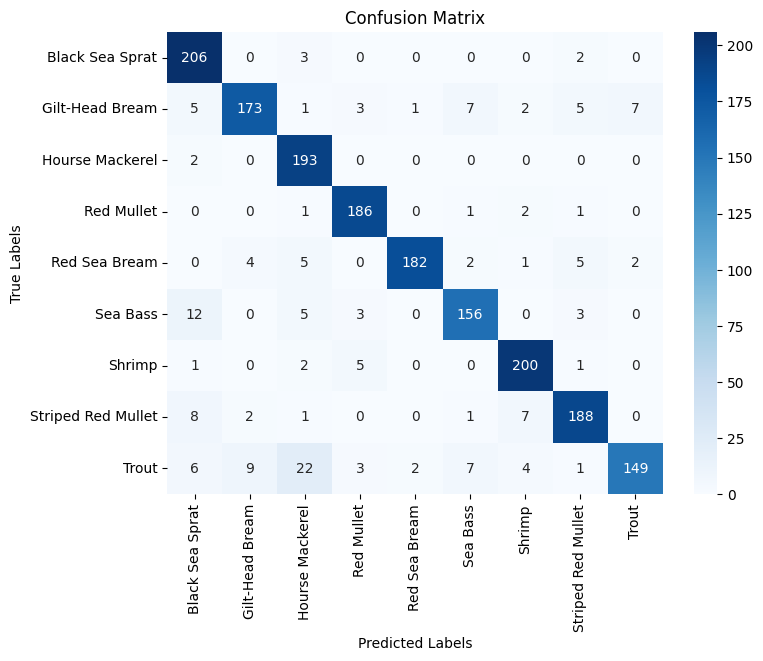

In [195]:
true_classes = test_images.classes
conf_matrix = confusion_matrix(true_classes, pred_classes)

# Sınıf etiketlerini alın
class_labels = list(test_images.class_indices.keys())

# Konfüzyon matrisini görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**true_classes = test_images.classes**: Bu satır, test görüntülerinin gerçek sınıf etiketlerini true_classes değişkenine atıyor. 

**conf_matrix = confusion_matrix(true_classes, pred_classes)**: Bu satır, true_classes (gerçek sınıf etiketleri) ve pred_classes (modelin tahmin ettiği sınıf etiketleri) arasındaki konfüzyon matrisini hesaplıyor. Konfüzyon matrisi, modelin doğru ve yanlış sınıflandırma performansını gösterir. 

**class_labels = list(test_images.class_indices.keys())**: Bu satır, test veri kümesindeki sınıf etiketlerinin listesini alıyor. Aşağıdaki kod bloğu, konfüzyon matrisini görselleştiriyor. 

**plt.figure(figsize=(8, 6))**: Görselleştirme için 8x6 boyutunda bir figür oluşturuyor. 

**sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)**: Konfüzyon matrisini bir ısı haritası (heatmap) olarak görselleştiriyor. Matrisdeki değerleri metin olarak gösteriyor, mavi renkler kullanıyor ve sütun/satır etiketleri olarak sınıf etiketlerini kullanıyor. 

**plt.xlabel('Predicted Labels')**: X ekseni etiketini "Predicted Labels" olarak ayarlıyor. 

**plt.ylabel('True Labels')**: Y ekseni etiketini "True Labels" olarak ayarlıyor. 

**plt.title('Confusion Matrix')**: Grafik başlığını "Confusion Matrix" olarak ayarlıyor.

**plt.show()**: Oluşturulan grafiği görüntülüyor. Konfüzyon matrisi, modelin farklı sınıflar için doğru ve yanlış tahminlerini açık bir şekilde gösterir. Bu görselleştirme, modelin performansını anlamak ve iyileştirmek için önemli bir araçtır.

Bu kod parçası, eğitilen modelin test verileri üzerindeki sınıflandırma performans raporunu yazdırıyor.

In [196]:
print(classification_report(true_classes, pred_classes, target_names=class_labels))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.86      0.98      0.91       211
   Gilt-Head Bream       0.92      0.85      0.88       204
   Hourse Mackerel       0.83      0.99      0.90       195
        Red Mullet       0.93      0.97      0.95       191
     Red Sea Bream       0.98      0.91      0.94       201
          Sea Bass       0.90      0.87      0.88       179
            Shrimp       0.93      0.96      0.94       209
Striped Red Mullet       0.91      0.91      0.91       207
             Trout       0.94      0.73      0.83       203

          accuracy                           0.91      1800
         macro avg       0.91      0.91      0.91      1800
      weighted avg       0.91      0.91      0.91      1800



**classification_report()** fonksiyonu, gerçek sınıf etiketleri (true_classes) ve modelin tahmin ettiği sınıf etiketleri (pred_classes) arasındaki sınıflandırma performansını rapor eder. **target_names=class_labels** parametresi, sınıf etiketlerinin listesini sağlıyor. Bu, raporun daha anlaşılır olması için kullanılır. Fonksiyon, aşağıdaki performans ölçümlerini içeren bir metin çıktısı döndürür: Hassasiyet (Precision) Duyarlılık (Recall) F1-skor Destek (Support)

Bu kod, modelin test verileri üzerindeki performansını görsel olarak incelemek için kullanışlıdır. Her görüntü için, gerçek ve tahmin edilen sınıflar renk kodlaması ile gösterilir, bu da modelin hangi sınıfları doğru tahmin ettiğini ve hangi sınıflarda hata yaptığını kolayca analiz etmeye yardımcı olur.

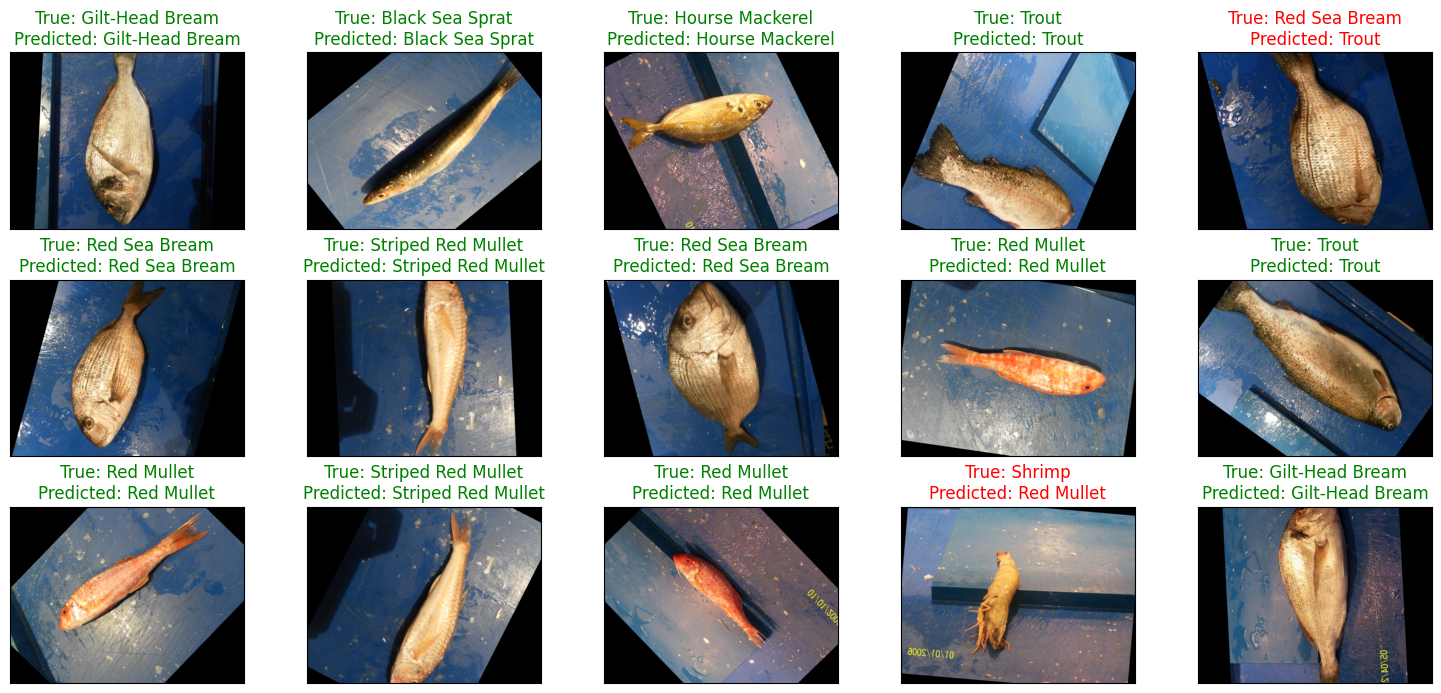

In [197]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_images.filepaths[i]))
    if test_images.labels[i] == pred_classes[i]:
        color = 'green'  
    else:
        color = 'red'    
    ax.set_title(f"True: {class_labels[test_images.labels[i]]}\nPredicted: {class_labels[pred_classes[i]]}", color = color)  

plt.tight_layout()
plt.show()

# Alt Grafiklerin Oluşturulması: 

**figsize=(15, 7)**, figürün boyutunu ayarlıyor. 

**subplot_kw={'xticks': [], 'yticks': []}** ile her bir alt grafikte X ve Y ekseninin işaretleri gizleniyor.

**Görüntülerin ve Tahminlerin Görselleştirilmesi**: döngü, axes.flat ile alt grafikleri düz bir dizi gibi ele alarak her bir alt grafikte test görüntülerini (**test_images.filepaths[i]**) gösterir.

**plt.imread()** fonksiyonu, belirtilen dosya yolundan görüntüyü okur ve **imshow()** ile görüntü alt grafikte gösterilir.

**Gerçek ve Tahmin Edilen Sınıfların Renk Kodlaması**: koşul, gerçek etiket ile modelin tahmin ettiği etiketin eşit olup olmadığını kontrol eder. Eğer eşitse, başlık yeşil; değilse kırmızı renkte gösterilecektir.

**Başlıkların Ayarlanması**: Her bir alt grafikte, gerçek sınıf (True) ve tahmin edilen sınıf (Predicted) başlık olarak ayarlanır. Başlık, yukarıda belirlenen renkte görünür.

**Düzeni Ayarlama ve Gösterme**: **plt.tight_layout()** fonksiyonu, alt grafiklerin arasında daha iyi bir düzen sağlamak için boşlukları otomatik olarak ayarlar. **plt.show()** fonksiyonu, oluşturulan grafiği görüntüler.